# Block 7 Übung 4: Visualisierung von Laborparametern für die Kohorten

## Bibliotheken & Konfiguration

In [1]:
packages <- c("readr", "dplyr", "tidyr", "ggplot2")
install.packages(setdiff(packages, rownames(installed.packages())))
lapply(packages, require, character.only = TRUE)

base_url <- "https://raw.githubusercontent.com/ganslats/TMF-School-Datenanalyse-Visualisierung/master/Rohdaten/"

Lade nötiges Paket: readr

Lade nötiges Paket: dplyr


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union


Lade nötiges Paket: tidyr

Lade nötiges Paket: ggplot2



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

## MIMIC III-Basisdaten laden

In [2]:
# Patientenstammdaten laden
mimic.patients.raw <- read_csv(paste(base_url, "mimic-iii-demo/PATIENTS.csv", sep=""),
                               col_types = cols(row_id = col_integer(), subject_id = col_integer(), gender = col_character(), dob = col_datetime(format = ""), dod = col_datetime(format = ""), dod_hosp = col_datetime(format = ""), dod_ssn = col_datetime(format = ""), expire_flag = col_double()))

# Behandlungsfälle laden
mimic.admissions.raw <- read_csv(paste(base_url, "mimic-iii-demo/ADMISSIONS.csv", sep=""),
                                 col_types = cols(  row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), admittime = col_datetime(format = ""), dischtime = col_datetime(format = ""), deathtime = col_datetime(format = ""), admission_type = col_character(), admission_location = col_character(), discharge_location = col_character(), insurance = col_character(), language = col_character(), religion = col_character(), marital_status = col_character(), ethnicity = col_character(), edregtime = col_datetime(format = ""), edouttime = col_datetime(format = ""), diagnosis = col_character(), hospital_expire_flag = col_double(), has_chartevents_data = col_double()))

# Intensivaufenthalte laden
mimic.icustays.raw <- read_csv(paste(base_url, "mimic-iii-demo/ICUSTAYS.csv", sep=""),
                               col_types = cols(row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), icustay_id = col_integer(), dbsource = col_character(), first_careunit = col_character(), last_careunit = col_character(), first_wardid = col_double(), last_wardid = col_double(), intime = col_datetime(format = ""), outtime = col_datetime(format = ""), los = col_double()))


## MIMIC III-Diagnosen laden & Bezeichner ergänzen

In [3]:
# Diagnosen laden
mimic.diagnoses.raw <- read_csv(paste(base_url, "mimic-iii-demo/DIAGNOSES_ICD.csv", sep=""),
                                col_types = cols(row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), seq_num = col_integer(), icd9_code = col_character()))

# Diagnosebezeichner laden
mimic.d_icd_diagnoses.raw <- read_csv(paste(base_url, "mimic-iii-demo/D_ICD_DIAGNOSES.csv", sep=""),
                                      col_types = cols(row_id = col_integer(), icd9_code = col_character(), short_title = col_character(), long_title = col_character()))

# Diagnosebezeichner hinzufügen
mimic.diagnoses.annotated <- mimic.diagnoses.raw %>% inner_join(mimic.d_icd_diagnoses.raw %>% select(icd9_code, short_title, long_title), by = "icd9_code")

## MIMIC III-Labordaten laden & Bezeichner ergänzen

In [4]:
# Laborbefunde laden
mimic.labevents.raw <- read_csv(paste(base_url, "mimic-iii-demo/LABEVENTS.csv", sep=""),
                                col_types = cols(row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), itemid = col_integer(), charttime = col_datetime(format = ""), value = col_character(), valuenum = col_double(), valueuom = col_character(), flag = col_character()))

# Bezeichner laden
mimic.d_labitems.raw <- read_csv(paste(base_url, "mimic-iii-demo/D_LABITEMS.csv", sep=""),
                                 col_types = cols(row_id = col_integer(), itemid = col_integer(), label = col_character(), fluid = col_character(), category = col_character(), loinc_code = col_character()))

# Bezeichner hinzufügen
mimic.labevents.annotated <- mimic.labevents.raw %>% 
  inner_join(mimic.d_labitems.raw %>% select(itemid, label, fluid, category, loinc_code), by = "itemid")

head(mimic.labevents.annotated)

row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag,label,fluid,category,loinc_code
<int>,<int>,<int>,<int>,<dttm>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
6244563,10006,NA,50868,2164-09-24 20:21:00,19,19,mEq/L,NA,Anion Gap,Blood,Chemistry,1863-0
6244564,10006,NA,50882,2164-09-24 20:21:00,27,27,mEq/L,NA,Bicarbonate,Blood,Chemistry,1963-8
6244565,10006,NA,50893,2164-09-24 20:21:00,10.0,10,mg/dL,NA,"Calcium, Total",Blood,Chemistry,2000-8
6244566,10006,NA,50902,2164-09-24 20:21:00,97,97,mEq/L,NA,Chloride,Blood,Chemistry,2075-0
6244567,10006,NA,50912,2164-09-24 20:21:00,7.0,7,mg/dL,abnormal,Creatinine,Blood,Chemistry,2160-0
6244568,10006,NA,50931,2164-09-24 20:21:00,126,126,mg/dL,abnormal,Glucose,Blood,Chemistry,2345-7


## Kohorten für Sepsis (sep), akuten Myokardinfarkt (ami) und akutes Nierenversagen (acf) erneut selektieren

In [5]:
# Sepsis-Kohorte
cohort.sep <- mimic.diagnoses.annotated %>% 
    filter(grepl("Sepsis", long_title)) %>%
    select(hadm_id) %>%
    distinct() %>%
    mutate(cohort_sep_flag = TRUE)

# AMI-Kohorte
cohort.ami <- mimic.diagnoses.annotated %>% 
    filter(grepl("Acute myocardial infarction", long_title)) %>%
    select(hadm_id) %>%
    distinct() %>%
    mutate(cohort_ami_flag = TRUE)

# ACF-Kohorte
cohort.acf <- mimic.diagnoses.annotated %>% 
    filter(grepl("Acute kidney failure", long_title)) %>%
    select(hadm_id) %>%
    distinct() %>%
    mutate(cohort_acf_flag = TRUE)

## Falltabelle (admissions) um die Kohorten-Flags ergänzen

Die Aufnahmetabelle wird im folgenden Block schrittweise mit left Joins um die Flags der 3 Kohorten ergänzt. Ergebnis ist die vollständige Falltabelle mit 3 zusätzlichen Spalten, in denen jeweils mit TRUE oder FALSE angegeben ist, ob dieser Fall in eine der drei Kohorten (oder ggf. mehrere) fällt.

In [6]:
cohort.all <- mimic.admissions.raw %>%
    left_join(cohort.sep, by = "hadm_id") %>%  # Sepsis-Kohorte hinzufügen
    left_join(cohort.ami, by = "hadm_id") %>%  # AMI-Kohorte hinzufügen
    left_join(cohort.acf, by = "hadm_id") %>%  # ACF-Kohorte hinzufügen
    replace_na(list(cohort_sep_flag = FALSE,   # "NA"-Einträge in den Kohorten-Flags durch FALSE ersetzen
                    cohort_ami_flag = FALSE,
                    cohort_acf_flag = FALSE))

head(cohort.all)

row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,⋯,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,cohort_sep_flag,cohort_ami_flag,cohort_acf_flag
<int>,<int>,<int>,<dttm>,<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dttm>,<dttm>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NA,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,⋯,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1,TRUE,FALSE,FALSE
12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,⋯,SINGLE,UNKNOWN/NOT SPECIFIED,NA,NA,HEPATITIS B,1,1,FALSE,FALSE,FALSE
12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,⋯,NA,UNKNOWN/NOT SPECIFIED,NA,NA,SEPSIS,1,1,FALSE,FALSE,FALSE
12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NA,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,⋯,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1,FALSE,FALSE,FALSE
12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,⋯,DIVORCED,WHITE,NA,NA,ALCOHOLIC HEPATITIS,1,1,FALSE,FALSE,TRUE
12277,10026,103770,2195-05-17 07:39:00,2195-05-24 11:45:00,NA,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,⋯,NA,WHITE,2195-05-17 01:49:00,2195-05-17 08:29:00,STROKE/TIA,0,1,FALSE,FALSE,FALSE


## Laboranalyte für Troponin (Herzenzym, u.a. bei Myokardinfarkt erhöht) heraussuchen

In [7]:
mimic.d_labitems.raw %>%
    filter(grepl("Troponin", label))

row_id,itemid,label,fluid,category,loinc_code
<int>,<int>,<chr>,<chr>,<chr>,<chr>
202,51002,Troponin I,Blood,Chemistry,10839-9
203,51003,Troponin T,Blood,Chemistry,6598-7


### Häufigkeit der gefundenen Troponin-Analyte in den Befunden anzeigen

In [8]:
mimic.labevents.annotated %>%
    filter(grepl("Troponin", label)) %>%
    group_by(label, fluid, loinc_code) %>%
    summarize(n = n(), .groups = "keep")

label,fluid,loinc_code,n
<chr>,<chr>,<chr>,<int>
Troponin I,Blood,10839-9,14
Troponin T,Blood,6598-7,288


## Verteilung der Troponin-Befunde mit/ohne Zugehörigkeit zur Herzinfarkt-Kohorte visualisieren

row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag,label,fluid,category,loinc_code,cohort_ami_flag
<int>,<int>,<int>,<int>,<dttm>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
6248364,10013,165520,51002,2125-10-05 00:00:00,GREATER THAN 50,NA,ng/ml,NA,Troponin I,Blood,Chemistry,10839-9,FALSE
6249564,10017,199207,51003,2149-05-26 12:03:00,<0.01,NA,ng/mL,NA,Troponin T,Blood,Chemistry,6598-7,FALSE
6249589,10017,199207,51003,2149-05-26 17:50:00,<0.01,NA,ng/mL,NA,Troponin T,Blood,Chemistry,6598-7,FALSE
6249614,10017,199207,51003,2149-05-27 05:38:00,<0.01,NA,ng/mL,NA,Troponin T,Blood,Chemistry,6598-7,FALSE
6250217,10019,177759,51003,2163-05-15 10:20:00,<0.01,NA,ng/mL,NA,Troponin T,Blood,Chemistry,6598-7,FALSE
6250702,10026,103770,51003,2195-05-17 01:10:00,<0.01,NA,ng/mL,NA,Troponin T,Blood,Chemistry,6598-7,FALSE


Warning message:
“Removed 57 rows containing non-finite values (`stat_boxplot()`).”


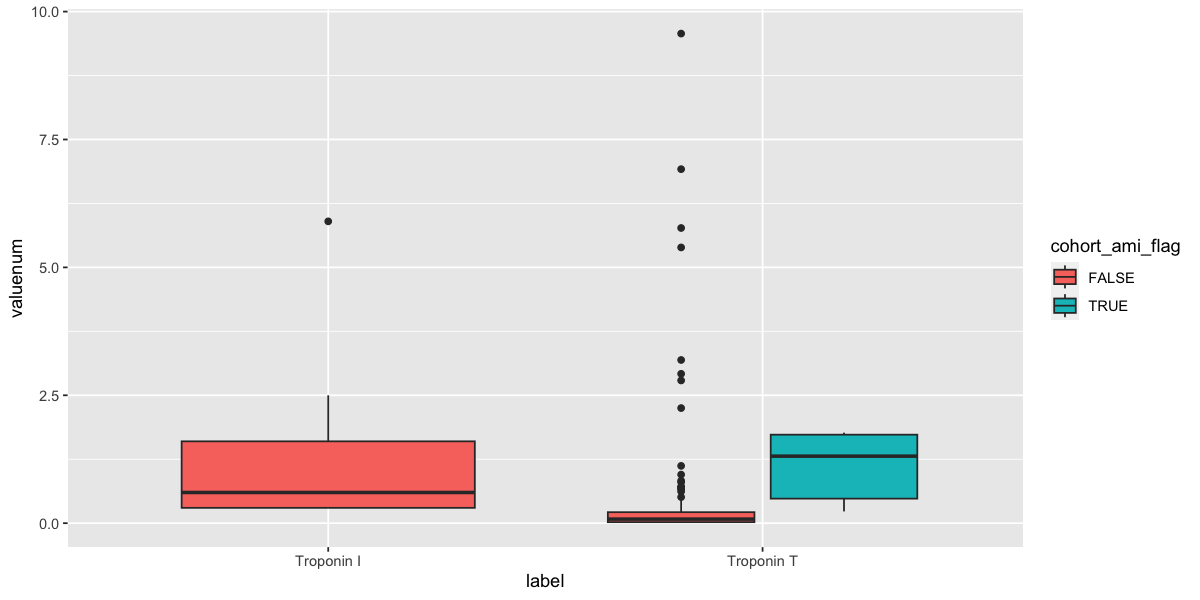

In [9]:
# Labordaten auf Troponin filtern & Kohortenflag ergänzen
troponin <- mimic.labevents.annotated %>%
    filter(grepl("Troponin", label)) %>%
    inner_join(cohort.all %>% select(hadm_id, cohort_ami_flag), by = "hadm_id")
head(troponin)

# Boxplot ausgeben
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data = troponin, aes(x = label, y = valuenum, fill = cohort_ami_flag)) +
    geom_boxplot()

## Aufgabe: Finden & visualisieren Sie passende Laborbefunde für die ACF- und Sepsis-Kohorten

Hier können Sie das Wissen aus dem Abschnitt 4, Demo 2 (Daten abfragen mit Tidyverse) und dem Abschnitt 6, Demo 1 (Daten visualisieren, Diagramme) anwenden.
* zugehörige Notebooks: [teil-4-demo-02-abfragen-tidyverse.ipynb](https://github.com/ganslats/TMF-School-2021-Block-7/blob/main/Notebooks/teil-4-demo-02-abfragen-tidyverse.ipynb), [teil-6-demo-01-visualisieren-diagramme.ipynb](https://github.com/ganslats/TMF-School-2021-Block-7/blob/main/Notebooks/teil-6-demo-01-visualisieren-diagramme.ipynb)
* nutzen Sie gerne auch das [ggplot2-Cheat Sheet von RStudio](https://github.com/rstudio/cheatsheets/raw/master/data-visualization-2.1.pdf)

Sonstige Tipps:
* nutzen Sie die `category`-Spalte in der Laborbefundtabelle und achten Sie auch darauf, dass gleichnamige Untersuchungen an verschiedenen Materialien (z.B. Blut, Urin) durchgeführt werden können
* falls der Bezeichner (`label`) eines Analyts für sich nicht eindeutig in Bezug auf das Untersuchungsmaterial ist, können Sie alternativ auch  dessen LOINC-Code als Filterkriterium nutzen, da es eindeutig inkl. des verwendeten Untersuchungsmaterials ist
* suchen Sie ggf. auch nach Synonymen, da die Benennung selbst innerhalb dieses Datensatzes nicht immer einheitlich ist (z.B. *Leukocytes* und *White blood cells*)

### Visualisierung Laborbefunde für die ACF-Kohorte (akutes Nierenversagen)

label,fluid,loinc_code,n
<chr>,<chr>,<chr>,<int>
"Albumin/Creatinine, Urine",Urine,14958-3,3
"Amylase/Creatinine Ratio, Urine",Urine,34235-2,1
Creatinine,Blood,2160-0,2175
"Creatinine, Ascites",Ascites,12191-3,5
"Creatinine, Body Fluid",Other Body Fluid,12190-5,1
"Creatinine, Pleural",Pleural,14399-0,1
"Creatinine, Urine",Urine,2161-8,97
Protein/Creatinine Ratio,Urine,2890-2,12


row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag,label,fluid,category,loinc_code,cohort_acf_flag
<int>,<int>,<int>,<int>,<dttm>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
6245210,10006,142345,50912,2164-10-23 17:38:00,3.0,3.0,mg/dL,abnormal,Creatinine,Blood,Chemistry,2160-0,FALSE
6245268,10006,142345,50912,2164-10-24 03:00:00,3.5,3.5,mg/dL,abnormal,Creatinine,Blood,Chemistry,2160-0,FALSE
6245295,10006,142345,50912,2164-10-25 09:30:00,5.3,5.3,mg/dL,abnormal,Creatinine,Blood,Chemistry,2160-0,FALSE
6245325,10006,142345,50912,2164-10-27 05:11:00,4.5,4.5,mg/dL,abnormal,Creatinine,Blood,Chemistry,2160-0,FALSE
6245349,10006,142345,50912,2164-10-28 09:00:00,6.1,6.1,mg/dL,abnormal,Creatinine,Blood,Chemistry,2160-0,FALSE
6245376,10006,142345,50912,2164-10-30 17:57:00,5.5,5.5,mg/dL,abnormal,Creatinine,Blood,Chemistry,2160-0,FALSE


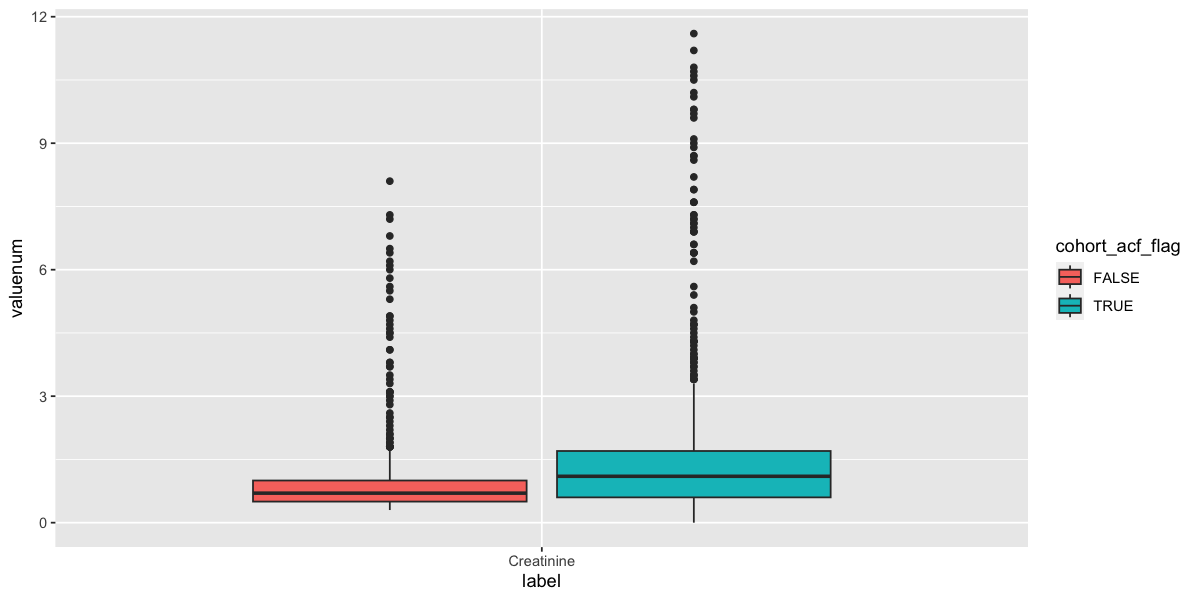

In [10]:
# Verfügbare Analyte & Befunde zum Kreatinin anzeigen
mimic.labevents.annotated %>%
    filter(grepl("Creatinine", label)) %>%
    group_by(label, fluid, loinc_code) %>%
    summarize(n = n(), .groups = "keep")

# Labordaten auf Kreatinin (im Blut) filtern & Kohortenflag ergänzen
creatinine <- mimic.labevents.annotated %>%
    filter(loinc_code == '2160-0') %>%
    inner_join(cohort.all %>% select(hadm_id, cohort_acf_flag), by = "hadm_id") %>%
    filter(valuenum < 100) # einzelnen Outlier ausfiltern
head(creatinine)

# Boxplot ausgeben
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data = creatinine, aes(x = label, y = valuenum, fill = cohort_acf_flag)) +
    geom_boxplot()

### Visualisierung Laborbefunde für die Sepsis-Kohorte

label,fluid,loinc_code,n
<chr>,<chr>,<chr>,<int>
White Blood Cells,Blood,804-5,2021


row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag,label,fluid,category,loinc_code,cohort_sep_flag
<int>,<int>,<int>,<int>,<dttm>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
6245240,10006,142345,51301,2164-10-23 17:38:00,7.8,7.8,K/uL,NA,White Blood Cells,Blood,Hematology,804-5,TRUE
6245288,10006,142345,51301,2164-10-24 03:00:00,4.6,4.6,K/uL,NA,White Blood Cells,Blood,Hematology,804-5,TRUE
6245311,10006,142345,51301,2164-10-25 09:30:00,4.1,4.1,K/uL,NA,White Blood Cells,Blood,Hematology,804-5,TRUE
6245320,10006,142345,51301,2164-10-26 06:20:00,3.4,3.4,K/uL,abnormal,White Blood Cells,Blood,Hematology,804-5,TRUE
6245344,10006,142345,51301,2164-10-27 05:11:00,3.7,3.7,K/uL,abnormal,White Blood Cells,Blood,Hematology,804-5,TRUE
6245369,10006,142345,51301,2164-10-28 09:00:00,2.9,2.9,K/uL,abnormal,White Blood Cells,Blood,Hematology,804-5,TRUE


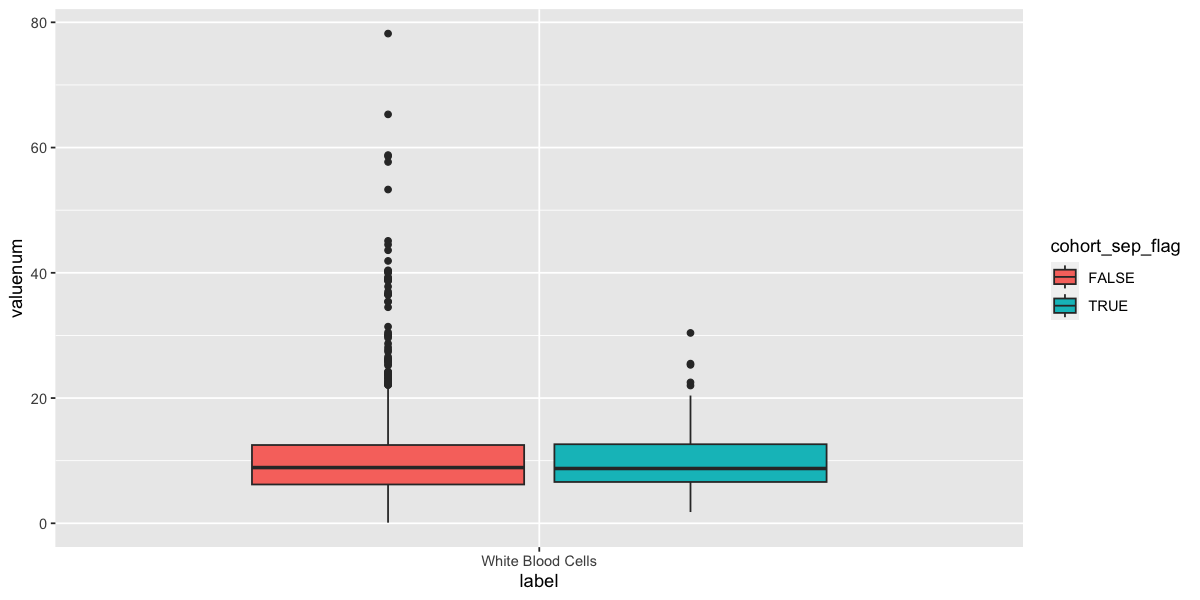

In [11]:
# Verfügbare Analyte & Befunde zu Leukozyten (White Blood Cells) anzeigen
mimic.labevents.annotated %>%
    filter(grepl("White Blood Cells", label)) %>%
    group_by(label, fluid, loinc_code) %>%
    summarize(n = n(), .groups = "keep")

# Labordaten auf Leukozyten filtern & Kohortenflag ergänzen
leukocytes <- mimic.labevents.annotated %>%
    filter(loinc_code == '804-5') %>%
    inner_join(cohort.all %>% select(hadm_id, cohort_sep_flag), by = "hadm_id")
head(leukocytes)

# Boxplot ausgeben
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data = leukocytes, aes(x = label, y = valuenum, fill = cohort_sep_flag)) +
    geom_boxplot()